In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('./../../DATASETS/augmented_movies_reviews.csv')
df.head()

Reviews  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           निर्माता:\nशीतल विनोद तलवार, मधु मन्न्टेना\n\nनिदेशक :\nरामगोपाल वर्मा\n\nकलाकार :\nविवेक ओबेरोई, सौत्रुघन सिन्हा, अभिमन्यु सिंह, सुशज़िंग सिंह, ज़रीन वहाब, आशीष विद्यार्थी, राजा कृष्णमूर्ति, श्रीनिवास राव\n\n* वयस्कों के लिए केवल * 16 कॉइल * 2 घंटे 14 मिनट\n\n\nजैसे ही "Raktcharitra-1" शुरू होता है, स्पष्टीकरण लिखा जाता है कि सभी पात्र और कहानी निम्नलिखित हैं। जटिलताएं।\n\n"रकटापारित्रा" की कहानी आंध्र प्रदेश और उनके सूरी द्वारा रवि परित्ता पर आधारित है।\n\nपहले भाग से पता चलता है कि (फिल्म में प्रताप) अपने पिता और उसके भाई की हत्या के बाद बदला लेता है। शामिल।\n\nजब प्रताप ने तीनों को मार डाला, तो नागमानी का बेटा, बुका (अभिमनु सिंह), उस पर बदला लेने के लिए अधीरता है। एक क्रूर विधि के साथ (एक गन्ने के साथ सिर को काटें, आरी मशीन से छाती को अलग करना, आदि)।\n\nPratap चुनाव जीतता है और एक अंधविश्वासी और एक राजनेता (वास्तव में nt राम राव) की मदद से बुक्का के भाई के खिलाफ बुका को समाप्त करता है। सूरी नामक पथ।\n\nफिल्म उन लोगों के लिए दिलचस्प हो सकती है जो आंध्र प्रदेश की नीति को बारीकी से जानते हैं, लेकिन जो लोग उन्हें नहीं जानते हैं, वे इस नियमित कहानी को पाते हैं, जिसम

In [3]:
# !pip install transformers torch pandas scikit-learn indic-nlp-library

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Load your dataset (ensure it's a DataFrame with columns 'text' and 'label')
data = df.copy()  # Replace with your dataset path

# Check data format
# assert 'text' in data.columns and 'label' in data.columns, "Dataset must have 'text' and 'label' columns"

texts = data['Reviews'].tolist()
labels = data['labels'].tolist()

# Map labels to integers if not already done
label_mapping = {label: idx for idx, label in enumerate(set(labels))}
data['labels'] = data['labels'].map(label_mapping)
labels = data['labels'].tolist()

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Load the tokenizer and model
model_name = 'albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize the datasets
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Check if GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Create a Dataset class
class HindiTextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

# Prepare datasets
train_dataset = HindiTextDataset(train_encodings, train_labels)
test_dataset = HindiTextDataset(test_encodings, test_labels)

# Define evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=3,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Predict on new Hindi text
def classify_text(text):
    tokens = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**tokens)
    prediction = torch.argmax(outputs.logits, dim=1)
    return list(label_mapping.keys())[prediction.item()]  # Return the original label

# Test the model on a sample
sample_text = "यह एक परीक्षण वाक्य है।"  # Replace with your Hindi text
predicted_label = classify_text(sample_text)
print(f"Predicted Label for '{sample_text}': {predicted_label}")


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/lenovo/.local/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.098130,0.418011,0.246448,0.174733,0.418011
2,1.096000,1.091749,0.418011,0.246448,0.174733,0.418011
3,1.093000,1.090761,0.418683,0.247906,0.486006,0.418683
4,1.093000,1.085046,0.418011,0.246448,0.174733,0.418011
5,1.094200,1.085560,0.418011,0.246448,0.174733,0.418011
6,1.092100,1.095560,0.418011,0.246448,0.174733,0.418011
7,1.089400,1.088197,0.418011,0.246448,0.174733,0.418011
8,1.089400,1.084543,0.418011,0.246448,0.174733,0.418011
9,1.090200,1.082567,0.418011,0.246448,0.174733,0.418011
10,1.089500,1.084619,0.418011,0.246448,0.174733,0.418011


/home/lenovo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lenovo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lenovo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lenovo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification

Test Results: {'eval_loss': 1.0733294486999512, 'eval_accuracy': 0.4314516129032258, 'eval_f1': 0.38750993231676073, 'eval_precision': 0.42177928312891294, 'eval_recall': 0.4314516129032258, 'eval_runtime': 20.5282, 'eval_samples_per_second': 72.486, 'eval_steps_per_second': 4.53, 'epoch': 36.0}
Predicted Label for 'यह एक परीक्षण वाक्य है।': positive


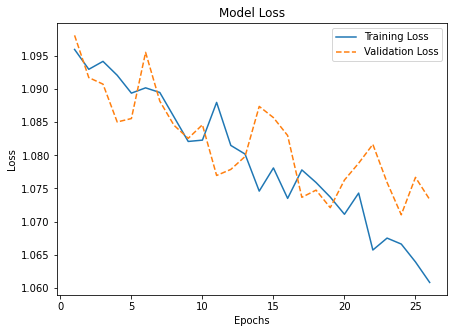

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the training log (replace 'training_log.json' with your actual log file if needed)
indic_log_file = "./results/checkpoint-13392/trainer_state.json"  # Replace with your actual log file path

with open(indic_log_file, "r") as f:
    indic_logs = json.load(f)

# Extract metrics
training_loss = [entry['loss'] for entry in indic_logs['log_history'] if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in indic_logs['log_history'] if 'eval_loss' in entry]
eval_accuracy = [entry['eval_accuracy'] for entry in indic_logs['log_history'] if 'eval_accuracy' in entry]
epochs = range(1, len(training_loss) + 1)



# Plot Training and Evaluation Loss
plt.figure(figsize=(7, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs[:len(training_loss)], eval_loss[:len(training_loss)], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

